##  CNN做MNIST分类
refer: https://github.com/hjptriplebee/AlexNet_with_tensorflow/blob/master/alexnet.py

In [1]:
import numpy as np
import tensorflow as tf

# 设置按需使用GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

## 1.导入数据，用 tensorflow 导入

In [2]:
# 用tensorflow 导入数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
# 看看咱们样本的数量
print mnist.test.labels.shape
print mnist.train.labels.shape

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(10000, 10)
(55000, 10)


## 2. 构建网络

In [3]:
# 定义卷积层
def conv2d(x, filter_shape, strides_x, strides_y, padding, name):
    """ 
    Args:
        x: 4-D inputs. [batch_size, in_height, in_width, in_channels]
        filter_shape: A list of ints.[filter_height, filter_width, in_channels, out_channels]
        strides: A list of ints. 1-D tensor of length 4. The stride of the sliding window for each dimension of input.
        padding: A string from: "SAME", "VALID". The type of padding algorithm to use.
    Returns:
        h_conv:  A 4-D tensor. [batch_size, out_height, out_width, out_channels]. 
        if padding is 'SAME', then out_height==in_height. 
        else, out_height = in_height - filter_height + 1.
        the same for out_width.
    """
    assert padding in ['SAME', 'VALID']
    strides=[1,strides_x, strides_y,1]
    with tf.variable_scope(name):
        W_conv = tf.get_variable('w', shape=filter_shape)
        b_conv = tf.get_variable('b', shape=[filter_shape[-1]])
        h_conv = tf.nn.conv2d(x, W_conv, strides=strides, padding=padding)
        h_conv_relu = tf.nn.relu(h_conv + b_conv)
    return h_conv_relu
    

def max_pooling(x, k_height, k_width, strides_x, strides_y, padding='SAME'):
    """max pooling layer."""
    ksize=[1,k_height, k_width,1]
    strides=[1,strides_x, strides_y,1]
    h_pool = tf.nn.max_pool(x, ksize, strides, padding)
    return h_pool

def dropout(x, keep_prob, name=None):
    """dropout layer"""
    return tf.nn.dropout(x, keep_prob, name=name)

def fc(x, in_size, out_size, name, activation=None):
    """fully-connect
    Args:
        x: 2-D tensor, [batch_size, in_size]
        in_size: the size of input tensor.
        out_size: the size of output tensor.
        activation: 'relu' or 'sigmoid' or 'tanh'.
    Returns:
        h_fc: 2-D tensor, [batch_size, out_size].
    """
    if activation is not None:
        assert activation in ['relu', 'sigmoid', 'tanh'], 'Wrong activation function.'
    with tf.variable_scope(name):
        w = tf.get_variable('w', shape = [in_size, out_size], dtype=tf.float32)
        b = tf.get_variable('b', [out_size], dtype=tf.float32)
        h_fc = tf.nn.xw_plus_b(x, w, b)
        if activation == 'relu':
            return tf.nn.relu(h_fc)
        elif activation == 'tanh':
            return tf.nn.tanh(h_fc)
        elif activation == 'sigmoid':
            return tf.nn.sigmoid(h_fc)
        else:
            return h_fc

with tf.name_scope('inputs'):
    X_ = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])

# 把X转为卷积所需要的形式
X = tf.reshape(X_, [-1, 28, 28, 1])
h_conv1 = conv2d(X, [5, 5, 1, 32], 1, 1, 'SAME', 'conv1')
h_pool1 = max_pooling(h_conv1, 2, 2, 2, 2)

h_conv2 = conv2d(h_pool1, [5, 5, 32, 64], 1, 1, 'SAME', 'conv2')
h_pool2 = max_pooling(h_conv2, 2, 2, 2, 2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = fc(h_pool2_flat, 7*7*64, 1024, 'fc1', 'relu')

# dropout: 输出的维度和h_fc1一样，只是随机部分值被值为零
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
h_fc2 = fc(h_fc1_drop, 1024, 10, 'fc2')
y_conv = tf.nn.softmax(h_fc2)
print('Finished building network.')

Finished building network.


## 3.训练和评估

<b> 在测试的时候不使用 mini_batch， 那么测试的时候会占用较多的GPU（4497M），这在 notebook 交互式编程中是不推荐的。

In [4]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())
for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            X_:batch[0], y_: batch[1], keep_prob: 1.0})
        print "step %d, training accuracy %g"%(i, train_accuracy)
    train_step.run(feed_dict={X_: batch[0], y_: batch[1], keep_prob: 0.5})

print "test accuracy %g"%accuracy.eval(feed_dict={
    X_: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})

step 0, training accuracy 0
step 1000, training accuracy 0.98
step 2000, training accuracy 0.98
step 3000, training accuracy 0.98
step 4000, training accuracy 1
step 5000, training accuracy 1
step 6000, training accuracy 1
step 7000, training accuracy 0.96
step 8000, training accuracy 0.96
step 9000, training accuracy 1
test accuracy 0.9909


<b> 下面改成了 test 也用 mini_batch 的形式， 显存只用了 529M,所以还是很成功的。

In [5]:
# 题外话：在做这个例子的过程中遇到过：资源耗尽的错误，为什么？
# -> 因为之前每次做 train_acc  的时候用了全部的 55000 张图，显存爆了.

# 1.损失函数：cross_entropy
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
# 2.优化函数：AdamOptimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 3.预测准确结果统计
#　预测值中最大值（１）即分类结果，是否等于原始标签中的（１）的位置。argmax()取最大值所在的下标
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.arg_max(y_, 1))  
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# 如果一次性来做测试的话，可能占用的显存会比较多，所以测试的时候也可以设置较小的batch来看准确率
test_acc_sum = tf.Variable(0.0)
batch_acc = tf.placeholder(tf.float32)
new_test_acc_sum = tf.add(test_acc_sum, batch_acc)
update = tf.assign(test_acc_sum, new_test_acc_sum)

# 定义了变量必须要初始化，或者下面形式
sess.run(tf.global_variables_initializer())
# 或者某个变量单独初始化 如：
# x.initializer.run()

# 训练
for i in range(5000):
    X_batch, y_batch = mnist.train.next_batch(batch_size=50)
    if i % 500 == 0:
        train_accuracy = accuracy.eval(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 1.0})
        print "step %d, training acc %g" % (i, train_accuracy)
    train_step.run(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 0.5})  

# 全部训练完了再做测试，batch_size=100
for i in range(100): 
    X_batch, y_batch = mnist.test.next_batch(batch_size=100)
    test_acc = accuracy.eval(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 1.0})
    update.eval(feed_dict={batch_acc: test_acc})
    if (i+1) % 20 == 0:
        print "testing step %d, test_acc_sum %g" % (i+1, test_acc_sum.eval())
print " test_accuracy %g" % (test_acc_sum.eval() / 100.0)

step 0, training acc 0.12
step 500, training acc 0.96
step 1000, training acc 1
step 1500, training acc 0.96
step 2000, training acc 0.98
step 2500, training acc 0.96
step 3000, training acc 0.98
step 3500, training acc 0.96
step 4000, training acc 0.96
step 4500, training acc 1
testing step 20, test_acc_sum 19.78
testing step 40, test_acc_sum 39.57
testing step 60, test_acc_sum 59.3
testing step 80, test_acc_sum 78.99
testing step 100, test_acc_sum 98.78
 test_accuracy 0.9878


## 4. 查看网络中间结果

<b> 在学习 CNN 的过程中，老是看到他们用图片的形式展示了中间层卷积的输出。好吧，这下我必须得自己实现以下看看呀！！！</b>
<br/> 关于 python 图片操作主要有 matplotlib 和 PIL 两个库（refer to: http://www.cnblogs.com/yinxiangnan-charles/p/5928689.html）。
<br/>我们使用 matplotlib 来完成这个任务。

### 4.1 图像操作基础

In [6]:
# 我们先来看看数据是什么样的
img1 = mnist.train.images[1]
label1 = mnist.train.labels[1]
print label1  # 所以这个是数字 6 的图片
print 'img_data shape =', img1.shape  # 我们需要把它转为 28 * 28 的矩阵
img1.shape = [28, 28]

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
img_data shape = (784,)


In [7]:
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg  # 用于读取图片，这里用不上

print img1.shape

(28, 28)


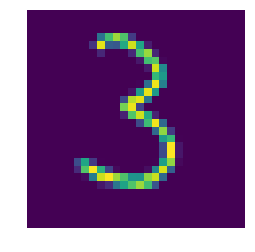

In [8]:
plt.imshow(img1)
plt.axis('off') # 不显示坐标轴
plt.show()   

好吧，是显示了图片，但是结果是热度图像。我们想显示的是灰度图像。

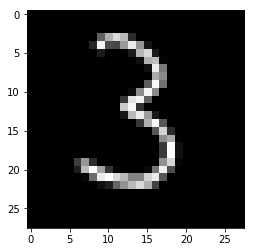

In [9]:
# 我们可以通过设置 cmap 参数来显示灰度图
plt.imshow(img1, cmap='gray') # 'hot' 是热度图
plt.show()

我们想看 Conv1 层的32个卷积滤波后的结果，显示在同一张图上。 python 中也有 plt.subplot(121) 这样的方法来帮我们解决这个问题。如下：先看两个试试

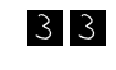

In [10]:
plt.subplot(4,8,1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.subplot(4,8,2)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

### 4.2 显示网络中间结果

好了，有了前面的图像操作基础，我们就该试试吧！！！

In [11]:
# 首先应该把 img1 转为正确的shape (None, 784)
X_img = img1.reshape([-1, 784])
y_img = mnist.train.labels[1].reshape([-1, 10])
# 我们要看 Conv1 的结果，即 h_conv1
result = h_conv1.eval(feed_dict={X_: X_img, y_: y_img, keep_prob: 1.0})
print result.shape
print type(result)

(1, 28, 28, 32)
<type 'numpy.ndarray'>


好的，我们成功的计算得到了 h_conv1，那么赶紧 imshow() 看看吧！！！

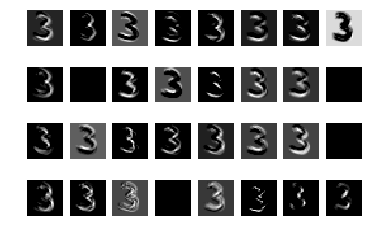

In [12]:
for _ in xrange(32):
    show_img = result[:,:,:,_]
    show_img.shape = [28, 28]
    plt.subplot(4, 8, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

哈哈，成功啦！从上面的结果中，我们可以看到不同的滤波器（卷积核）学习到了不同的特征。比如第一行中，第一个滤波器学习到了边缘信息，第5个卷积核，则学习到了骨干的信息。感觉好有趣，不由自主的想对另一个数字看看。

In [13]:
# 输出前10个看看，我选择数字 9 来试试
print mnist.train.labels[:10]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


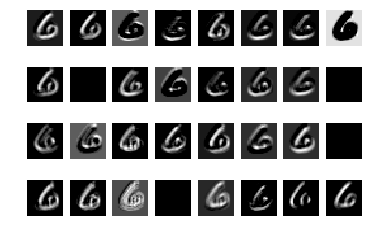

In [14]:
# 首先应该把 img1 转为正确的shape (None, 784)
X_img = mnist.train.images[2].reshape([-1, 784])
y_img = mnist.train.labels[1].reshape([-1, 10]) # 这个标签只要维度一致就行了
result = h_conv1.eval(feed_dict={X_: X_img, y_: y_img, keep_prob: 1.0})

for _ in xrange(32):
    show_img = result[:,:,:,_]
    show_img.shape = [28, 28]
    plt.subplot(4, 8, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()

第一个核还是主要学习到了边缘特征，第五个核还是学到了骨干特征（当然在某种程度上）。好吧，本次就到这啦！